This Notebook contains an example of using the given VaLLA implementation over 1D regression datasets.

# Imports

In [3]:
# Notebook reload options
%load_ext autoreload
%autoreload 2

In [4]:

# Global Imports
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.cluster.vq import kmeans2

# Local Imports
sys.path.append("..")
from utils.pytorch_learning import fit_map, fit
from src.valla import VaLLARegression, VaLLARegressionBackend
from utils.metrics import Regression
from src.ella import ELLA_Regression
from utils.models import get_mlp, create_ad_hoc_mlp
from laplace import Laplace

from utils.dataset import get_dataset

# Experimental settings

Theese are the parameters that determine the experiments. Most of these values are set to their default value. Please refer to `utils/process_flass.py` to know more about each parameter.

In [5]:
params = {
        "num_inducing": 20,
        "bnn_structure": [50, 50],
        "MAP_lr": 0.001,
        "MAP_iterations": 3000,
        "lr": 0.001,
        "iterations": 20000,
        "activation": torch.nn.Tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "bb_alpha": 0,
        "prior_std": 1,
        "ll_std": 1
}

Set seed for reproductibility.

In [6]:
torch.manual_seed(params["seed"])

Load Dataset and desired split.

In [7]:
dataset = get_dataset("synthetic")
train_dataset, val_dataset, test_dataset = dataset.get_split()

Number of samples:  76
Input dimension:  1
Label dimension:  1
Labels mean value:  0
Labels standard deviation:  1


Create Data loaders for training and test partitions.

In [8]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

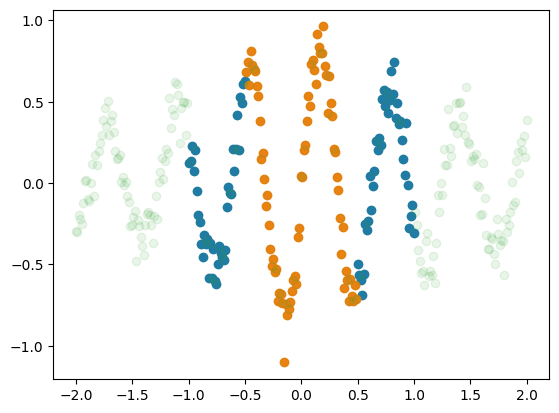

In [9]:

plt.scatter(train_dataset.inputs, 
                train_dataset.targets, 
                label="Training points")


plt.scatter(val_dataset.inputs, 
                val_dataset.targets, 
                label="Val points")


plt.scatter(test_dataset.inputs, 
                test_dataset.targets, 
                label="Test points", alpha=0.1)



# MAP Learning

In [12]:
f = get_mlp(
    train_dataset.inputs.shape[1],
    train_dataset.targets.shape[1],
    params["bnn_structure"],
    params["activation"],
    device=params["device"],
    dtype=params["dtype"],
)

# Define optimizer and compile model
opt = torch.optim.AdamW(f.parameters(), lr=params["MAP_lr"], weight_decay=0.1)
criterion = torch.nn.MSELoss()

# Set the number of training samples to generate
# Train the model
start = timer()

loss = fit_map(
    f,
    train_loader,
    opt,
    criterion=torch.nn.MSELoss(),
    use_tqdm=True,
    return_loss=True,
    iterations=10000,
    device=params["device"],
)
end = timer()

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=1, bias=True)
)


Training :   0%|          | 0/10000 [00:00<?, ? iteration/s]

Training : 100%|██████████| 10000/10000 [00:21<00:00, 471.66 iteration/s]


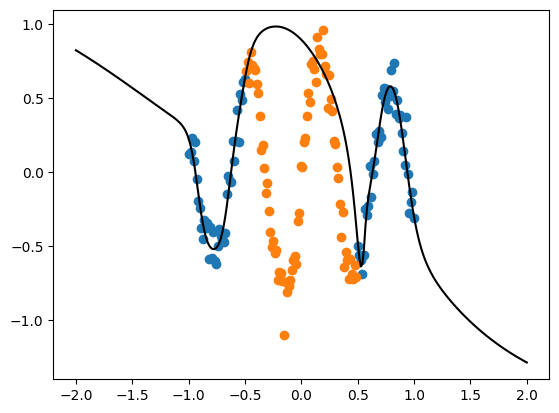

In [13]:

plt.scatter(train_dataset.inputs, 
                train_dataset.targets, 
                label="Training points")


plt.scatter(val_dataset.inputs, 
                val_dataset.targets, 
                label="Training points")



sort = np.argsort(test_dataset.inputs.flatten())


plt.plot(
    test_dataset.inputs.flatten()[sort],
    f(torch.tensor(test_dataset.inputs)).detach().numpy().flatten()[sort],
    label="Predictions",
    color="black",
)
plt.show()

In [14]:
# 'all', 'subnetwork' and 'last_layer'
subset = "all"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "full"
X = test_dataset.inputs
la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)
la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True, dtype=params["dtype"]), torch.ones(
    1, requires_grad=True, dtype = params["dtype"]
)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in tqdm(range(100)):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

#la.optimize_prior_precision(method='CV', val_loader=val_loader)

prior_std = np.sqrt(1 / np.exp(log_prior.detach().numpy())).item()
log_variance = 2*log_sigma.detach().numpy().item()


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


In [15]:
def distribution_plot(model_predictive, name = None):
    plt.rcParams["pdf.fonttype"] = 42
    plt.figure(figsize=(16,7))
    mean, var = model_predictive(torch.tensor(test_dataset.inputs, dtype = params["dtype"]))
    mean = mean.detach().numpy()
    var = var.detach().numpy() + np.exp(log_variance)
    std = np.sqrt(var).flatten()
    sort = np.argsort(test_dataset.inputs.flatten())

    fig = plt.scatter(train_dataset.inputs, 
                    train_dataset.targets, 
                    color = "black")

    plt.scatter(val_dataset.inputs, 
                    val_dataset.targets, 
                    color = "tomato")


    plt.plot(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort],
        color="cornflowerblue",
    )
    plt.fill_between(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort] - 2 * std[sort],
        mean.flatten()[sort] + 2 * std[sort],
        alpha=0.2,
        color="cornflowerblue",
    )

    #plt.axis('off')
    plt.ylim(-7. ,7)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig("../demos/plots/" + name+ ".pdf", format="pdf", bbox_inches='tight')
    plt.show()

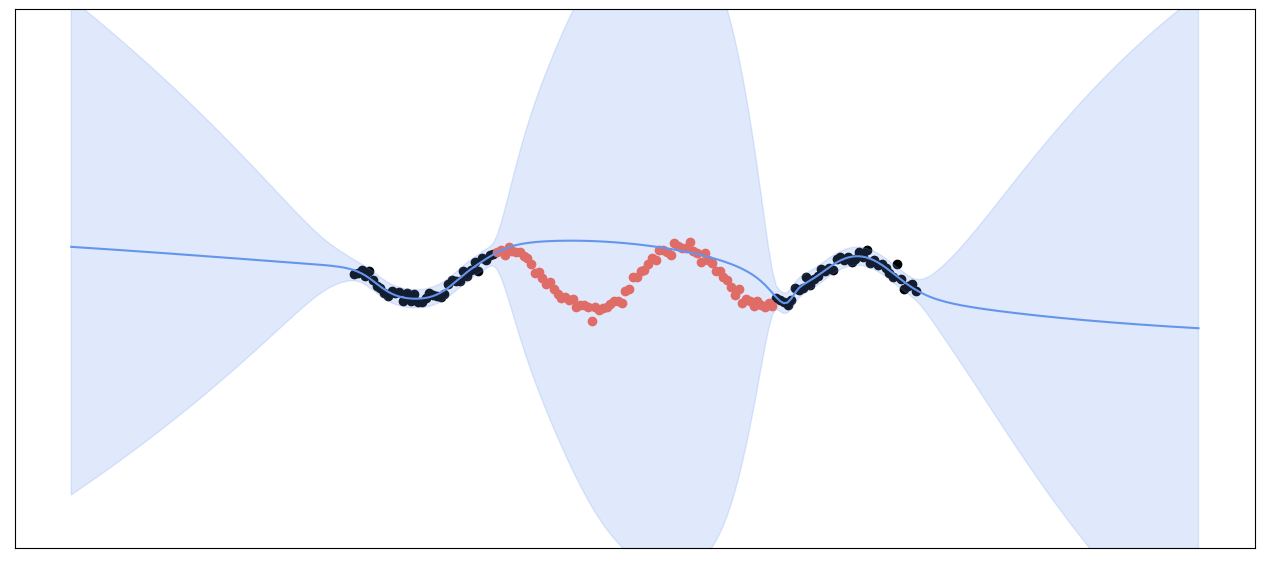

In [17]:
distribution_plot(la._glm_predictive_distribution, "LLA_val")

# ELLA

In [19]:
Ms = [5, 10, 20, 50]

Training : 100%|██████████| 1/1 [00:00<00:00, 40.80iteration/s]

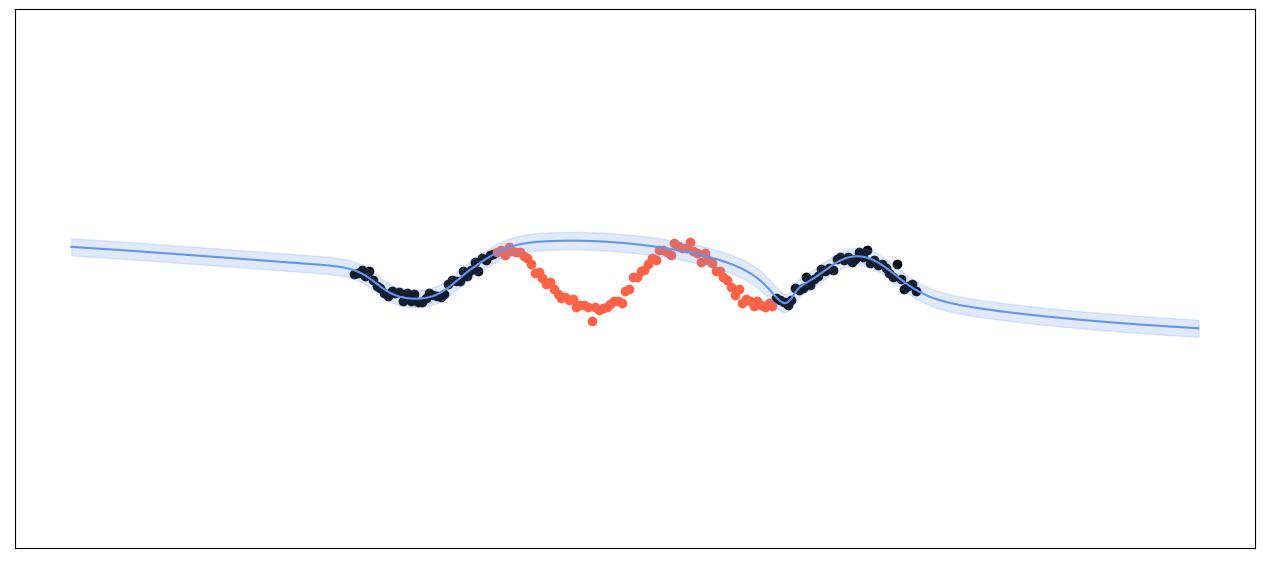

Training : 100%|██████████| 1/1 [00:00<00:00, 34.73iteration/s]


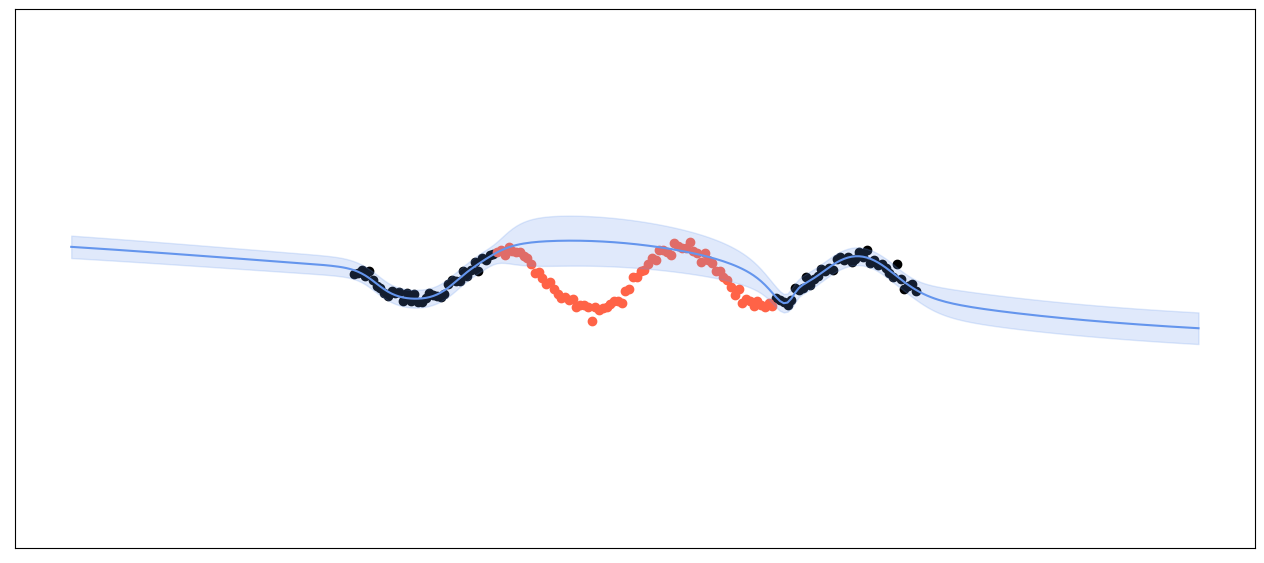

Training : 100%|██████████| 1/1 [00:00<00:00, 55.88iteration/s]


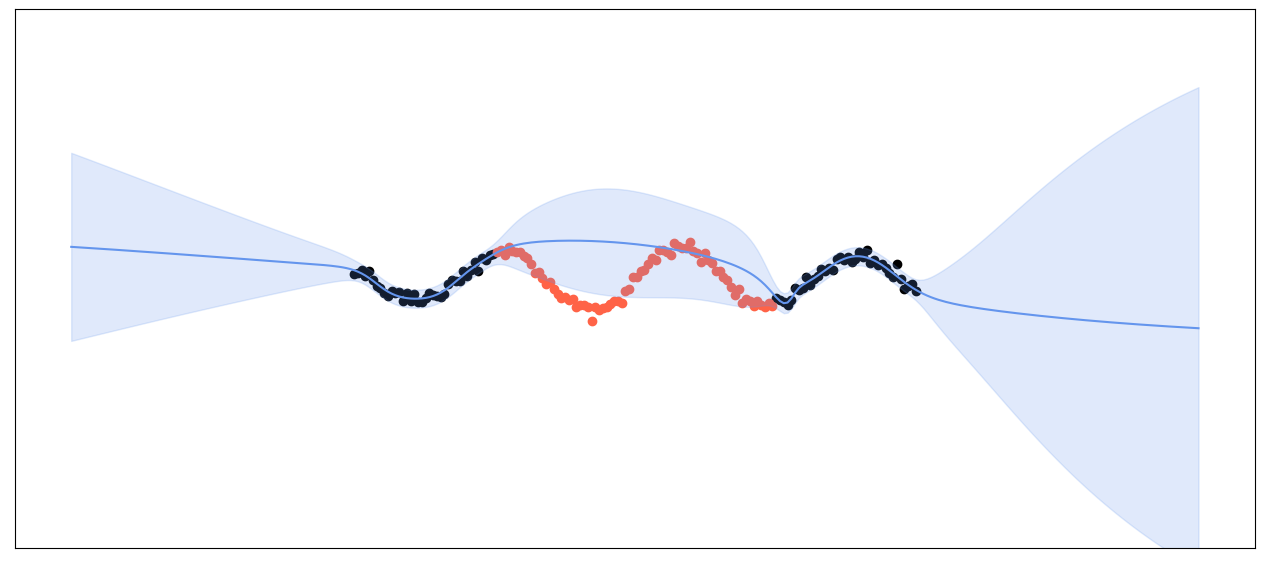

Training : 100%|██████████| 1/1 [00:00<00:00, 44.31iteration/s]


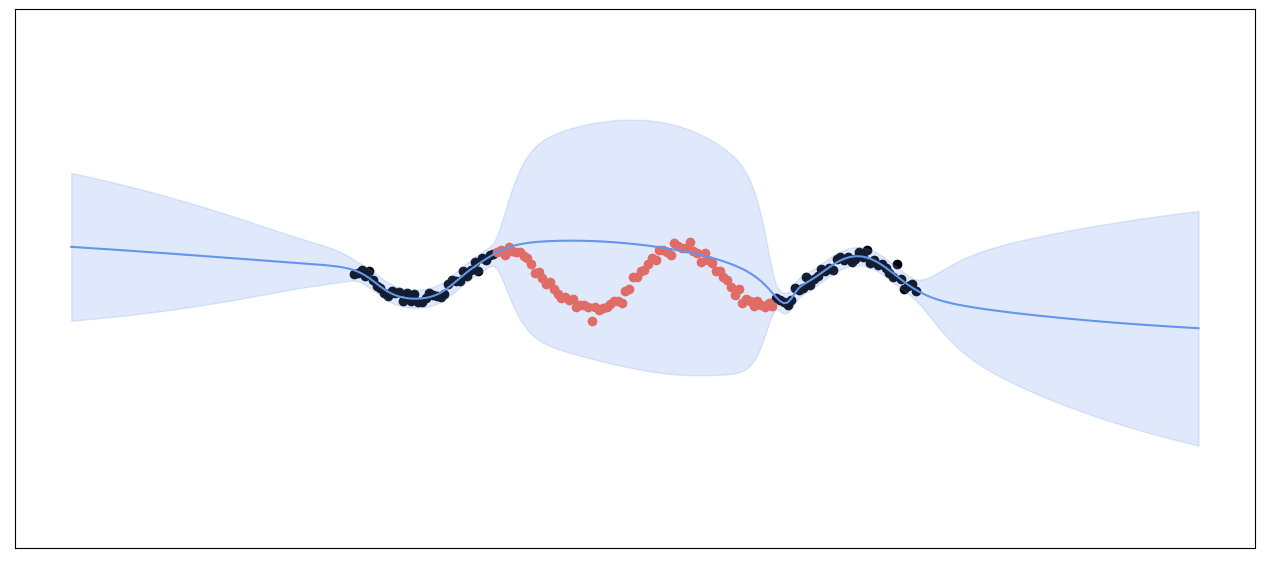

In [20]:
for m in Ms:
    ella = ELLA_Regression(
        create_ad_hoc_mlp(f),
        f.output_size,
        m,
        min(m, 20),
        prior_std=prior_std,
        log_variance = log_variance,
        seed=params["seed"],
        y_mean=train_dataset.targets_mean,
        y_std=train_dataset.targets_std,
        device=params["device"],
        dtype=params["dtype"],
    )
    ella.fit_loader_val(
            torch.tensor(train_dataset.inputs, 
                         device=params["device"], 
                         dtype=params["dtype"]),
            torch.tensor(train_dataset.targets,
                         device=params["device"], 
                         dtype=params["dtype"]),
            train_loader,
            val_loader = val_loader,
            verbose = True,
        )
    distribution_plot(ella.predict_f, "ELLA_val_M={}".format(m))

# VaLLA

Define DVIP model.

Backend or not can be used, in case of using the backend change `VaLLARegression` for `VaLLARegressionBackpack` and un-comment the backend line.

In [21]:
from src.backpack_interface import BackPackInterface
backend = BackPackInterface(f, train_dataset.output_dim)

Initializing inducing classes with 1 different classes
Validation NLL: 3.314122438430786
Validation NLL: 3.131423234939575
Validation NLL: 3.048077344894409
Validation NLL: 2.976644515991211
Validation NLL: 2.9126851558685303
Validation NLL: 2.8547770977020264
Validation NLL: 2.801852226257324
Validation NLL: 2.7530930042266846
Validation NLL: 2.7078614234924316
Validation NLL: 2.6656506061553955
Validation NLL: 2.626051664352417
Validation NLL: 2.588731050491333
Validation NLL: 2.553412675857544
Validation NLL: 2.519866466522217
Validation NLL: 2.487898349761963
Validation NLL: 2.457343339920044
Validation NLL: 2.4280612468719482
Validation NLL: 2.399930477142334
Validation NLL: 2.3728461265563965
Validation NLL: 2.3467166423797607
Validation NLL: 2.3214621543884277
Validation NLL: 2.2970118522644043
Validation NLL: 2.273303747177124
Validation NLL: 2.2502822875976562
Validation NLL: 2.227898120880127
Validation NLL: 2.2061071395874023
Validation NLL: 2.1848700046539307
Validation NLL

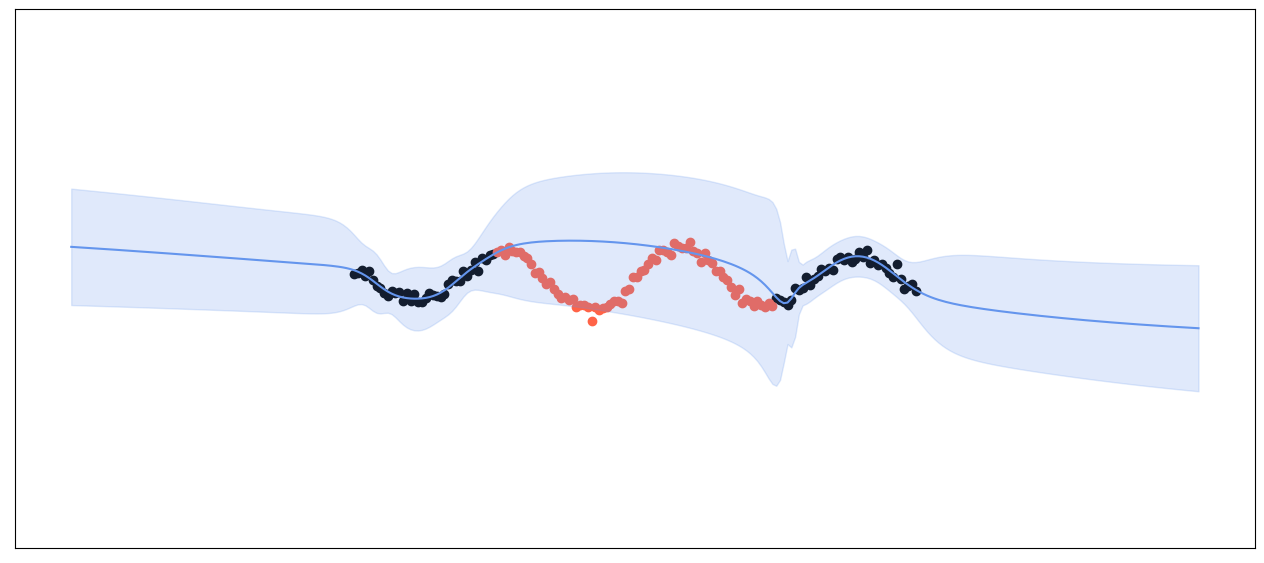

Initializing inducing classes with 1 different classes
Validation NLL: 3.0627448558807373
Validation NLL: 2.6907083988189697
Validation NLL: 2.634652614593506
Validation NLL: 2.575723886489868
Validation NLL: 2.520150661468506
Validation NLL: 2.46834397315979
Validation NLL: 2.4201204776763916
Validation NLL: 2.3751487731933594
Validation NLL: 2.333080530166626
Validation NLL: 2.2935919761657715
Validation NLL: 2.2563958168029785
Validation NLL: 2.2212398052215576
Validation NLL: 2.1879031658172607
Validation NLL: 2.156191825866699
Validation NLL: 2.125932216644287
Validation NLL: 2.0969631671905518
Validation NLL: 2.069126605987549
Validation NLL: 2.042250394821167
Validation NLL: 2.0161194801330566
Validation NLL: 1.990454912185669
Validation NLL: 1.9650135040283203
Validation NLL: 1.9398720264434814
Validation NLL: 1.9155771732330322
Validation NLL: 1.8923004865646362
Validation NLL: 1.8699284791946411
Validation NLL: 1.8483622074127197
Validation NLL: 1.8275316953659058
Validation 

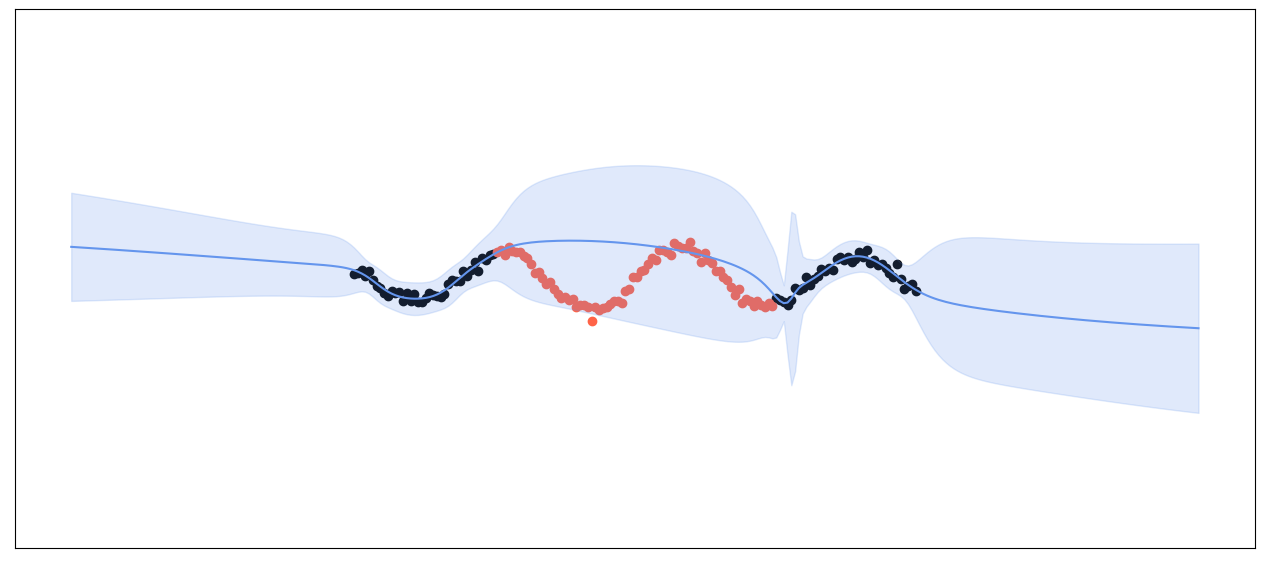

Initializing inducing classes with 1 different classes
Validation NLL: 2.963075876235962
Validation NLL: 2.504997491836548
Validation NLL: 2.4460229873657227
Validation NLL: 2.394636869430542
Validation NLL: 2.3505842685699463
Validation NLL: 2.345975637435913
Validation NLL: 2.3377349376678467
Validation NLL: 2.329563617706299
Validation NLL: 2.324380397796631
Validation NLL: 2.3216094970703125
Validation NLL: 2.3201019763946533
Validation NLL: 2.3190653324127197
Validation NLL: 2.318061113357544
Validation NLL: 2.3168818950653076
Validation NLL: 2.315453052520752
Validation NLL: 2.3137729167938232
Validation NLL: 2.3118746280670166
Validation NLL: 2.3098018169403076
Validation NLL: 2.3075942993164062
Validation NLL: 2.305280923843384
Validation NLL: 2.3028786182403564
Validation NLL: 2.3003945350646973
Validation NLL: 2.297828197479248
Validation NLL: 2.2951748371124268
Validation NLL: 2.292426824569702
Validation NLL: 2.2895758152008057
Validation NLL: 2.286613941192627
Validation N

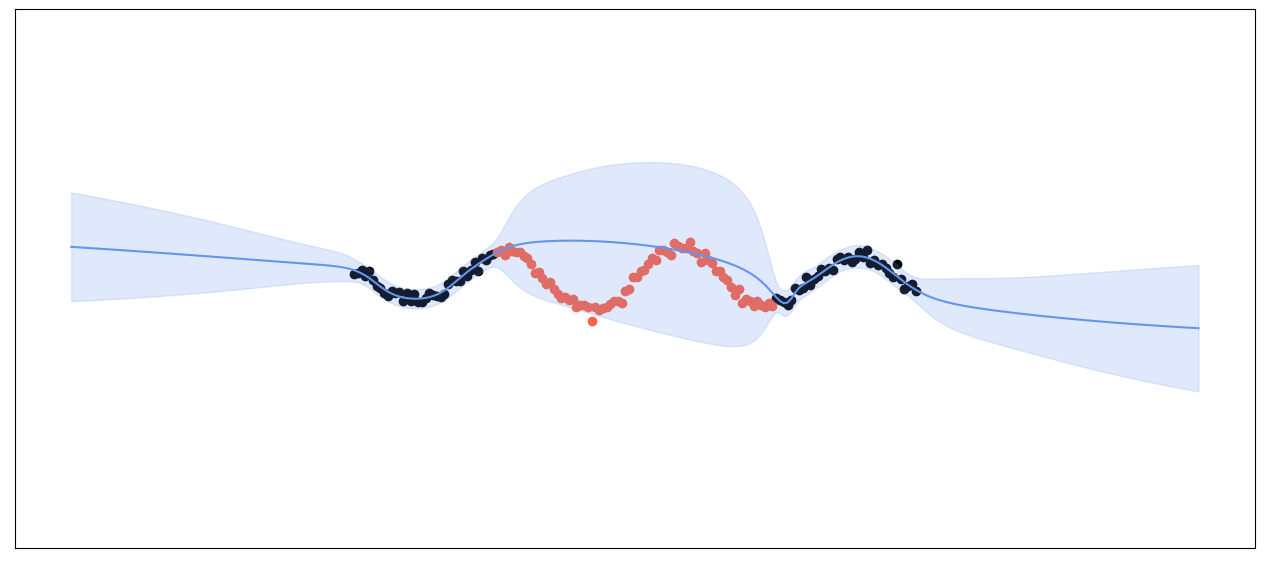

Initializing inducing classes with 1 different classes
Validation NLL: 2.5055277347564697
Validation NLL: 2.3451383113861084
Validation NLL: 2.262885570526123
Validation NLL: 2.1813511848449707
Validation NLL: 2.0905561447143555
Validation NLL: 2.0103578567504883
Validation NLL: 1.947301983833313
Validation NLL: 1.8933839797973633
Validation NLL: 1.8450628519058228
Validation NLL: 1.8008166551589966
Validation NLL: 1.7597531080245972
Validation NLL: 1.721247673034668
Validation NLL: 1.6848350763320923
Validation NLL: 1.6501671075820923
Validation NLL: 1.6169888973236084
Validation NLL: 1.5851223468780518
Validation NLL: 1.5544517040252686
Validation NLL: 1.5249145030975342
Validation NLL: 1.4964932203292847
Validation NLL: 1.469211220741272
Validation NLL: 1.4431294202804565
Validation NLL: 1.4183458089828491
Validation NLL: 1.3949967622756958
Validation NLL: 1.373259425163269
Validation NLL: 1.3533563613891602
Validation NLL: 1.335560917854309
Validation NLL: 1.3202043771743774
Valida

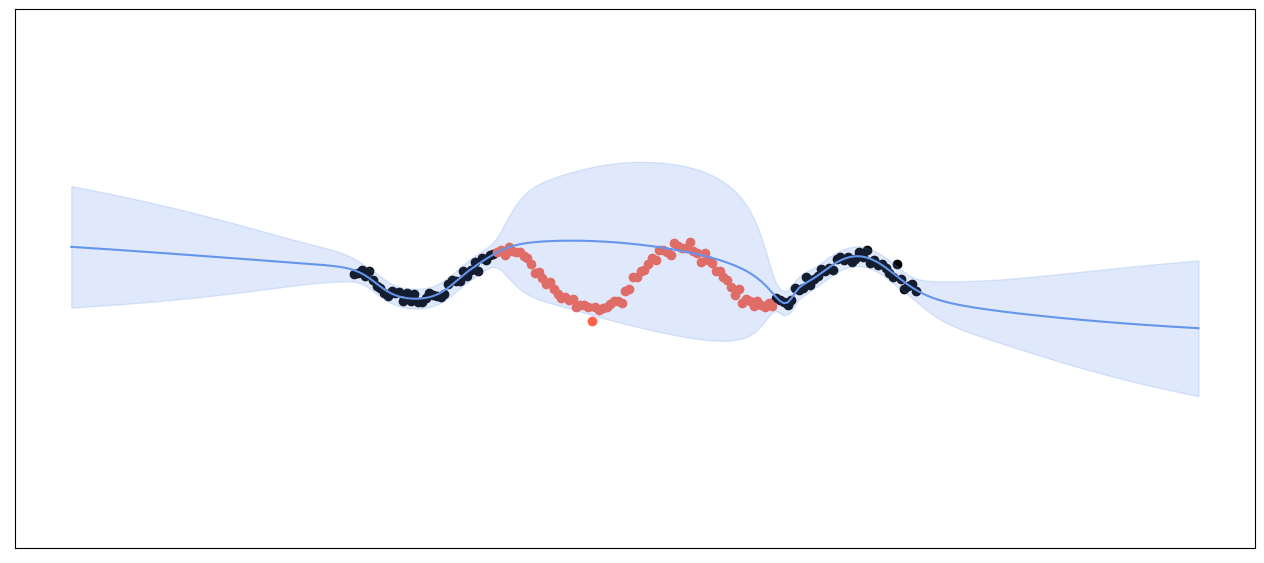

In [24]:
for m in Ms:
    Z = kmeans2(train_dataset.inputs, m, 
            minit="points", seed=params["seed"])[0]
    valla = VaLLARegression(
        create_ad_hoc_mlp(f),
        Z,
        alpha=params["bb_alpha"],
        prior_std=prior_std,
        log_variance=log_variance,
        #backend = backend,
        num_data=train_dataset.inputs.shape[0],
        output_dim=1,
        track_inducing_locations=True,
        y_mean=train_dataset.targets_mean,
        y_std=train_dataset.targets_std,
        device=params["device"],
        dtype=params["dtype"],
    )
    #valla.freeze_ll()
    #valla.freeze_prior()
    opt = torch.optim.Adam(valla.parameters(), lr=0.001)

    loss, val_loss = fit(
        valla,
        train_loader,
        opt,
        val_generator = val_loader,
        val_steps = 100,
        val_metrics= Regression,
        use_tqdm=False,
        return_loss=True,
        iterations=20000,
        device=params["device"],
    )
    distribution_plot(valla.predict_f, "VaLLA_val_M={}".format(m))

Initializing inducing classes with 1 different classes


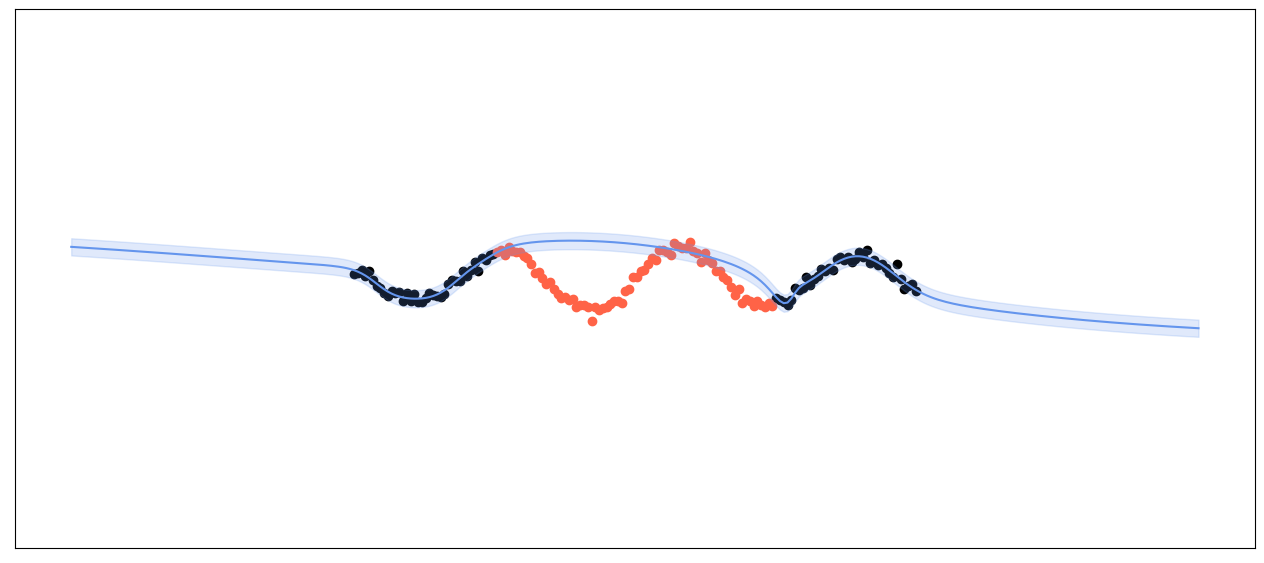

Initializing inducing classes with 1 different classes


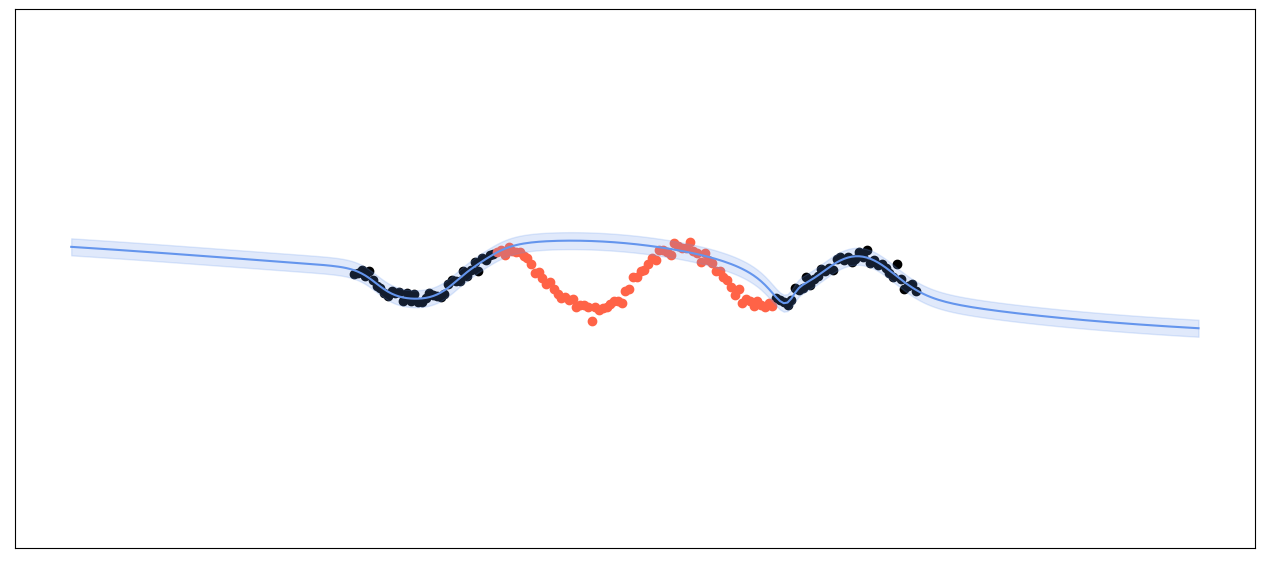

Initializing inducing classes with 1 different classes


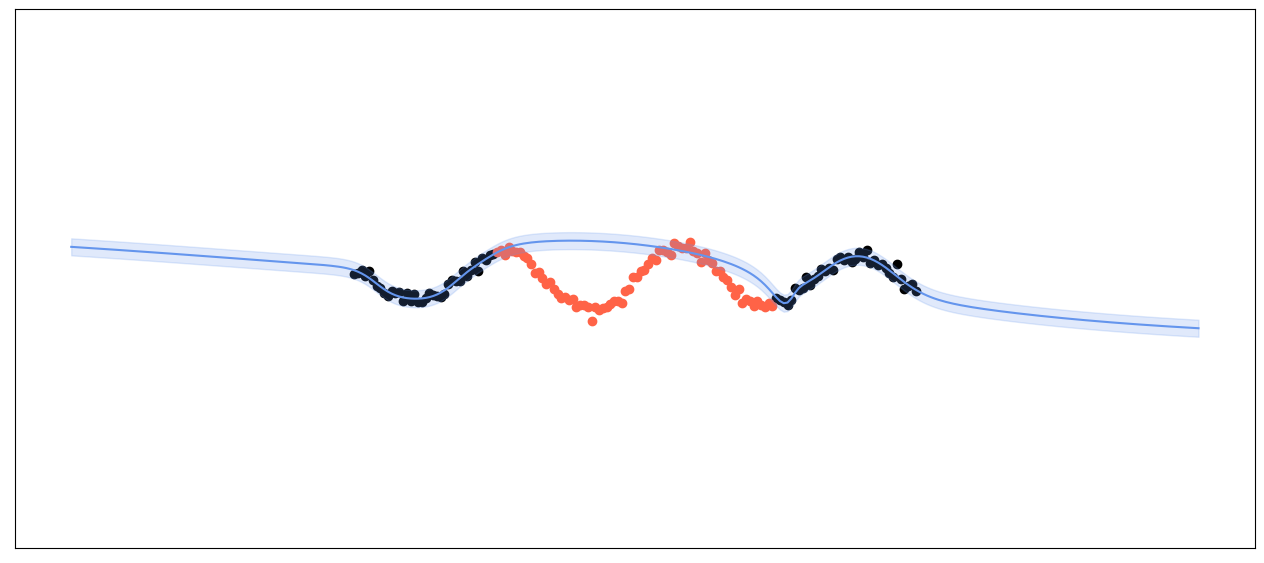

Initializing inducing classes with 1 different classes


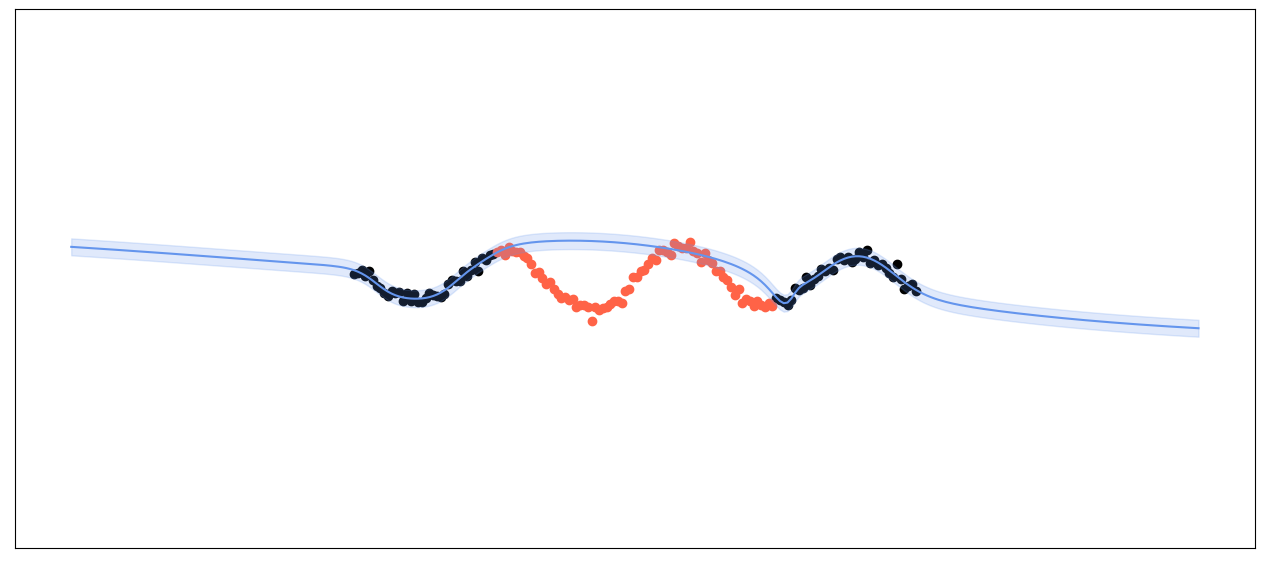

In [25]:
for m in Ms:
    Z = kmeans2(train_dataset.inputs, m, 
            minit="points", seed=params["seed"])[0]
    valla = VaLLARegression(
        create_ad_hoc_mlp(f),
        Z,
        alpha=params["bb_alpha"],
        prior_std=prior_std,
        log_variance=log_variance,
        #backend = backend,
        num_data=train_dataset.inputs.shape[0],
        output_dim=1,
        track_inducing_locations=True,
        y_mean=train_dataset.targets_mean,
        y_std=train_dataset.targets_std,
        device=params["device"],
        dtype=params["dtype"],
    )
    #valla.freeze_ll()
    #valla.freeze_prior()
    opt = torch.optim.Adam(valla.parameters(), lr=0.001)

    loss, val_loss = fit(
        valla,
        train_loader,
        opt,
        #val_generator = val_loader,
        #val_steps = 100,
        #val_metrics= Regression,
        use_tqdm=False,
        return_loss=True,
        iterations=20000,
        device=params["device"],
    )
    distribution_plot(valla.predict_f, "VaLLA_val2_M={}".format(m))